# 1. Simulación de variables aleatorias

## 1.1. CDF es conocida e invertible

Suponga que $f_X(x)=x\textrm{e}^{-\frac{x^2}{2}}\mathbf{1}_{x\geq0}$ (distribución Rayleigh)

1. Calule la CDF
2. Invierta la CDF
3. Simule $10^6$ observaciones
4. Dibuje el histograma y superpongalo a la PDF

In [1]:
import numpy as np # Algebra matricial
from math import exp
import matplotlib.pyplot as plt # gráficos
from scipy.stats import multivariate_t, invgamma
from scipy.optimize import minimize


import random # Simulacion aleatoria
random.seed( 0 ) # Fijando la semilla (reproducir resultados)
np.random.seed( 0 ) # Fijando la semilla (reproducir resultados)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

La CDF es
$$F_X(x)=\int_{-\infty}^xu\textrm{e}^{-\frac{u^2}{2}}du=1-\textrm{e}^{-\frac{x^2}{2}}$$
su inversa es
$$F_X^{-1}(u)=\sqrt{-2\log(1-u)}$$
creando $n=10^6$ simulaciones

In [2]:
nsample = 10**6
usim = np.random.uniform(0,1,(nsample,1))
xsim = np.sqrt(-2*np.log(1-usim))

generando gráficos

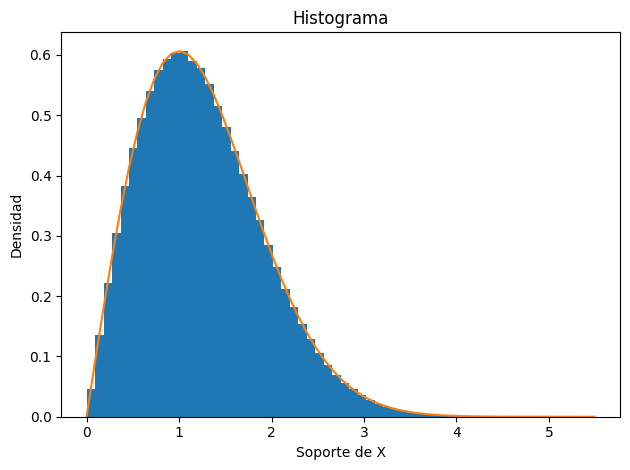

In [3]:
num_bins = 60
fig, ax = plt.subplots()
n, bins, patches = ax.hist(xsim, num_bins, density=1)
pdf = bins*np.exp(-bins**2/2)
ax.plot(bins, pdf)
ax.set_xlabel('Soporte de X')
ax.set_ylabel('Densidad')
ax.set_title(r'Histograma')
fig.tight_layout()

## 1.2. CDF no invertible: Aceptance-rejection algorithm
Del ejercicio anterior, suponga que $F_X(\cdot)$ no es invertible.
Definamos según la notación de las diapositivas:
* $h(x)=10^{-1}$ (i.e., $h\equiv U(0,10)$)
* $g(x)=x\textrm{e}^{-\frac{x^2}{2}}\mathbf{1}_{x\geq0}$

Calculemos $c$:
$$c=\sup_{x}\frac{g(x)}{h(x)}=\sup_{x}10x\textrm{e}^{-\frac{x^2}{2}}\mathbf{1}_{x\geq0}\Rightarrow x^*=1\text{ y }c=10\textrm{e}^{-\frac{1}{2}}$$

Construyamos una función que implemente el algoritmo:

$$g(x)=f(x)/k\text{ pero si hacemos }k=1\text{ entonces }0\leq\frac{g(x)}{ch(x)}\leq1$$

In [4]:
def get_AR_Rayleigh(c,n):
    count = 0
    rej   = 0
    x = np.zeros(shape=(n,1))
    while count < (n-1):
        # Simulación de U(0,10)
        z_candidato = 10*np.random.uniform(0,1)
        # Simulación de U(0,1)
        u = np.random.uniform(0,1)
        # Aceptar o rechazar
        f_de_candidato = z_candidato*exp(-z_candidato**2/2) #k=1
        h_de_candidato = 1.0/10
        if u <= f_de_candidato/(c*h_de_candidato):
            x[count,0] = z_candidato
            count  += 1
        else:
            rej += 1

    return x, rej

In [5]:
c = 10*exp(-1.0/2)*5
nsample = 5*10**4
xsim_AR, rej = get_AR_Rayleigh(c,nsample)

In [6]:
rej

1467772

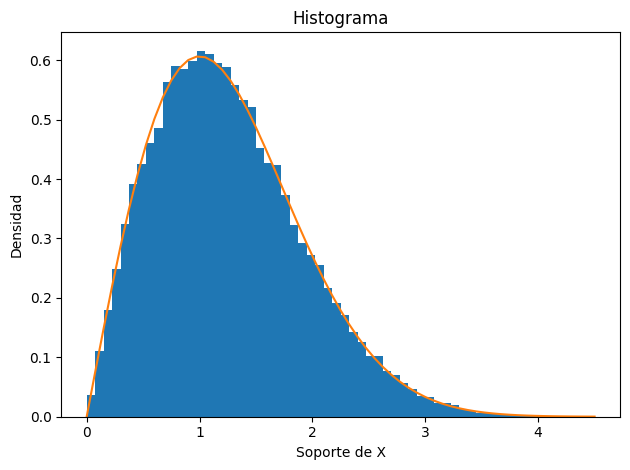

In [7]:
num_bins = 60
fig, ax = plt.subplots()
n, bins, patches = ax.hist(xsim_AR, num_bins, density=1)
pdf = bins*np.exp(-bins**2/2)
ax.plot(bins, pdf)
ax.set_xlabel('Soporte de X')
ax.set_ylabel('Densidad')
ax.set_title(r'Histograma')
fig.tight_layout()

## 1.3. Normal multivariada
Sea $X\sim\mathcal{N}(\mu,\Sigma)$ con $\mu=[0.5\ 5]$ y $\Sigma=\left[\begin{matrix}0.6 & -0.2\\ -0.2 & 0.1\end{matrix}\right]$ utilice la función ```np.random.randn``` para simular $10^6$ realizacioines de $X$

In [8]:
nsample = 10**6
mu = np.array([[0.5],[5]])
Sigma = np.array([[0.6, -0.2],[-0.2, 0.1]])
LTSigma = np.linalg.cholesky(Sigma)
zsim_vec = np.random.randn(2,nsample)
xsim_vec = np.dot(LTSigma,zsim_vec) + np.repeat(mu,nsample,axis=1)

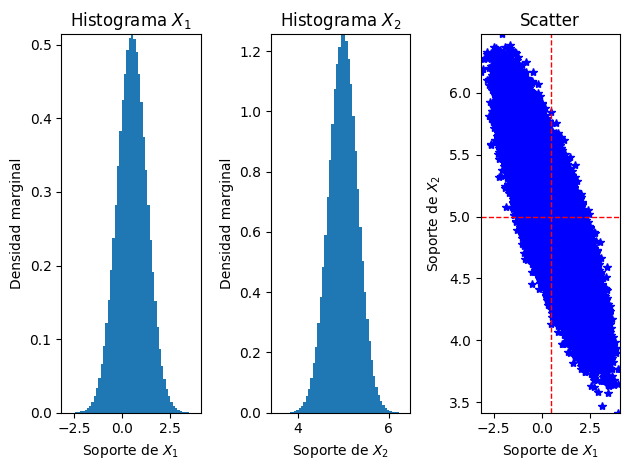

In [9]:
num_bins = 60
fig, (ax0, ax1, ax3) = plt.subplots(1,3)
n, bins, patches = ax0.hist(xsim_vec[0,:], num_bins, density=1)
ax0.set_xlabel('Soporte de $X_1$')
ax0.set_ylabel('Densidad marginal')
ax0.set_title(r'Histograma $X_1$')
ax0.autoscale(enable=True, axis='both', tight=True)

n, bins, patches = ax1.hist(xsim_vec[1,:], num_bins, density=1)
ax1.set_xlabel('Soporte de $X_2$')
ax1.set_ylabel('Densidad marginal')
ax1.set_title(r'Histograma $X_2$')
ax1.autoscale(enable=True, axis='both', tight=True)


line0, = ax3.plot(xsim_vec[0,:], xsim_vec[1,:], 'b*')
ax3.axhline(5, color='red', lw=1,ls='--')
ax3.axvline(0.5, color='red', lw=1,ls='--')
ax3.set_xlabel('Soporte de $X_1$')
ax3.set_ylabel('Soporte de $X_2$')
ax3.set_title(r'Scatter')
ax3.autoscale(enable=True, axis='both', tight=True)

plt.tight_layout()

## Ilustrar GS y MH

A modo de ilustración, consideremos la siguiente función de distribución:
$$\mathbf{X}|z \sim \mathcal{N}(\boldsymbol{\mu},z\boldsymbol{\Omega})\text{ con }z\sim\Gamma^{-1}(\alpha,\beta),$$
donde $\boldsymbol{\mu}\in\mathbb{R}^{2\times1}$, $\boldsymbol{\Omega}$ es una matriz definida positiva de dimensiones $2\times2$, $\alpha>0$ y $\beta>0$.

El objetivo del ejercicio es simular el par $(\mathbf{X},z)$.

Para ello, se emplearán tres metodologías: simulación directa de la función de densidad conjunta o marginales, muestreo de Gibbs (Gibb-sampling) y algoritmo de Metrópolis-Hastings.

### Simulación directa

No contamos con la densidad conjunta. En el caso de las densidades marginales, se tiene la densidad marginal de $z$  pero no la de $\mathbf{X}$. Tratemos de derivar la densidades marginal faltante:

1. La densidad marginal de $z$, dado que $z$ es $\Gamma^{-1}$ es:
$$p(z)=\frac{\beta^{\alpha}}{\Gamma(\alpha)}z^{-\alpha-1}\exp\left(-\frac{\beta}{z}\right)$$
2. Dado que $\mathbf{X}|z \sim \mathcal{N}(\boldsymbol{\mu},z\boldsymbol{\Omega})$ entonces
$$p(\mathbf{X}|z)=\frac{1}{(2\pi) |z\boldsymbol{\Omega}|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'(z\boldsymbol{\Omega})^{-1}(\mathbf{X} - \boldsymbol{\mu})\right)$$

3. La densidad marginal de $\mathbf{X}$ se obtiene al integrar $z$ en todo su soporte
$$p(\mathbf{X})=\int_zp(\mathbf{X},z)\mathrm{d}z=\int_zp(\mathbf{X}|z)p(z)\mathrm{d}z$$

4. Reemplazando $p(\mathbf{X}|z)$ y $p(z)$ en $p(\mathbf{X})$ resulta en:
$$p(\mathbf{X})=\int_z\frac{1}{(2\pi) |z\boldsymbol{\Omega}|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'(z\boldsymbol{\Omega})^{-1}(\mathbf{X} - \boldsymbol{\mu})\right)\frac{\beta^{\alpha}}{\Gamma(\alpha)}z^{-\alpha-1}\exp\left(-\frac{\beta}{z}\right)\mathrm{d}z$$
reduciendo
$$p(\mathbf{X})=\int_z\frac{1}{(2\pi) |\boldsymbol{\Omega}|^{1/2}} \exp\left[-\left(\frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'\boldsymbol{\Omega}^{-1}(\mathbf{X} - \boldsymbol{\mu})+\beta\right)z^{-1}\right]\frac{\beta^{\alpha}}{\Gamma(\alpha)}z^{-\alpha-2}\mathrm{d}z$$

5. Definir $\tilde{\beta}=\beta+\frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'\boldsymbol{\Omega}^{-1}(\mathbf{X} - \boldsymbol{\mu})$ y $\tilde{\alpha}=1+\alpha$ entonces
$$p(\mathbf{X})=\int_z\frac{1}{(2\pi) |\boldsymbol{\Omega}|^{1/2}} \exp\left[-\frac{\tilde{\beta}}{z}\right]\frac{\beta^{\tilde{\alpha}-1}}{\Gamma(\tilde{\alpha}-1)}z^{-\tilde{\alpha}-1}\mathrm{d}z$$
reacomodando
$$p(\mathbf{X})=\frac{1}{(2\pi) |\boldsymbol{\Omega}|^{1/2}} \frac{\beta^{\tilde{\alpha}-1}\Gamma(\tilde{\alpha})}{\tilde{\beta}^{\tilde{\alpha}}\Gamma(\tilde{\alpha}-1)}\int_z\frac{\tilde{\beta}^{\tilde{\alpha}}}{\Gamma(\tilde{\alpha})}z^{-\tilde{\alpha}-1}\exp\left[-\frac{\tilde{\beta}}{z}\right]\mathrm{d}z$$
note que $\int_z\frac{\tilde{\beta}^{\tilde{\alpha}}}{\Gamma(\tilde{\alpha})}z^{-\tilde{\alpha}-1}\exp\left[-\frac{\tilde{\beta}}{z}\right]\mathrm{d}z=1$ ya que es la PDF de una $\Gamma^{-1}$ de parámetros $\tilde{\alpha}$ y $\tilde{\beta}$. Entonces:
$$p(\mathbf{X})=\frac{1}{(2\pi) |\boldsymbol{\Omega}|^{1/2}} \frac{\beta^{\tilde{\alpha}-1}\Gamma(\tilde{\alpha})}{\tilde{\beta}^{\tilde{\alpha}}\Gamma(\tilde{\alpha}-1)}$$
revirtiendo las definiciones de $\tilde{\alpha}$ y $\tilde{\beta}$:
$$p(\mathbf{X})=\frac{1}{(2\pi) |\boldsymbol{\Omega}|^{1/2}} \frac{\beta^{\alpha}\Gamma(\alpha+1)}{\Gamma(\alpha)}\left[\beta + \frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'\boldsymbol{\Omega}^{-1}(\mathbf{X} - \boldsymbol{\mu})\right]^{-\alpha-1}$$
factorizando $\beta$ del corchete y reduciendo
$$p(\mathbf{X})=\frac{\Gamma(\alpha+1)}{\Gamma(\alpha)(2\beta)\pi |\boldsymbol{\Omega}|^{\frac{1}{2}}}\left[1+\frac{1}{2\beta}(\mathbf{X} - \boldsymbol{\mu})'\boldsymbol{\Omega}^{-1}(\mathbf{X} - \boldsymbol{\mu})\right]^{-\alpha-1}$$

6. La última expresión corresponde a una distribución $t$ con parámetro de localización $\boldsymbol{\mu}$, de forma $\boldsymbol{\Omega}$ y con $2\alpha=4\beta$ grados de libertad:
$$\mathbf{X}\sim\mathbf{t}\left(\boldsymbol{\mu},\boldsymbol{\Omega},2\alpha\right)$$


Dado que el valor medio de $z$ es $\mathrm{E}z=\frac{\beta}{\alpha-1}$. ¿Se puede simplemente hacer simulaciones de $\mathbf{X}$ con una $\mathcal{N}\left(\boldsymbol{\mu},\frac{\beta}{\alpha-1}\boldsymbol{\Omega}\right)$?

In [10]:
# Parameters
mu    = np.array([0.5, 1])
Omega = np.array([[0.5, 0.6], [0.6, 1.5]])
alpha = 2
beta  = 1
df    = 2*alpha
Ez    = beta/(alpha-1)

# Number of samples to draw
nsample = 10**5

In [11]:
Xs_normal = np.random.multivariate_normal(mu, Ez*Omega, size=nsample)
Xs = multivariate_t.rvs(loc=mu, shape=Omega, df=df, size=nsample)
zs = invgamma.rvs(a=alpha, scale=beta, size=nsample)

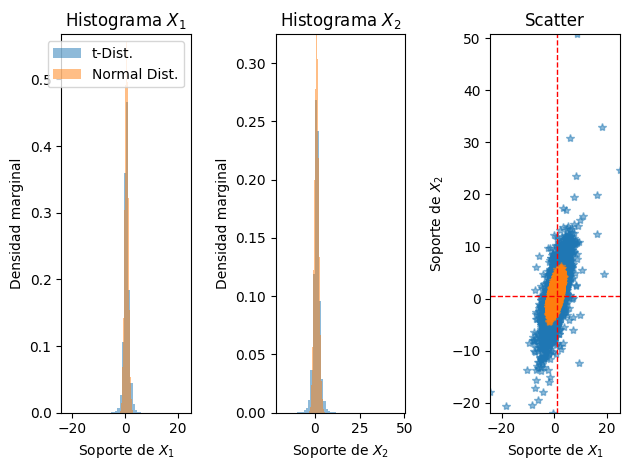

In [12]:
num_bins = 60
fig, (ax0, ax1, ax3) = plt.subplots(1,3)

ax0.hist(Xs[:,0], num_bins, density=True, alpha=0.5, label='t-Dist.')
ax0.hist(Xs_normal[:, 0], num_bins, density=True, alpha=0.5, label='Normal Dist.')
ax0.set_xlabel('Soporte de $X_1$')
ax0.set_ylabel('Densidad marginal')
ax0.set_title(r'Histograma $X_1$')
ax0.legend()
ax0.autoscale(enable=True, axis='both', tight=True)

ax1.hist(Xs[:,1], num_bins, density=True, alpha=0.5, label='t-Dist.')
ax1.hist(Xs_normal[:, 1], num_bins, density=True, alpha=0.5, label='Normal Dist.')
ax1.set_xlabel('Soporte de $X_2$')
ax1.set_ylabel('Densidad marginal')
ax1.set_title(r'Histograma $X_2$')
ax1.autoscale(enable=True, axis='both', tight=True)

ax3.plot(Xs[:,0], Xs[:,1], '*',alpha=0.5, label='t-Dist.')
ax3.plot(Xs_normal[:,0], Xs_normal[:,1], '*',alpha=0.5, label='Normal Dist.')
ax3.axhline(0.5, color='red', lw=1,ls='--')
ax3.axvline(1.0, color='red', lw=1,ls='--')
ax3.set_xlabel('Soporte de $X_1$')
ax3.set_ylabel('Soporte de $X_2$')
ax3.set_title(r'Scatter')
ax3.autoscale(enable=True, axis='both', tight=True)

plt.tight_layout()

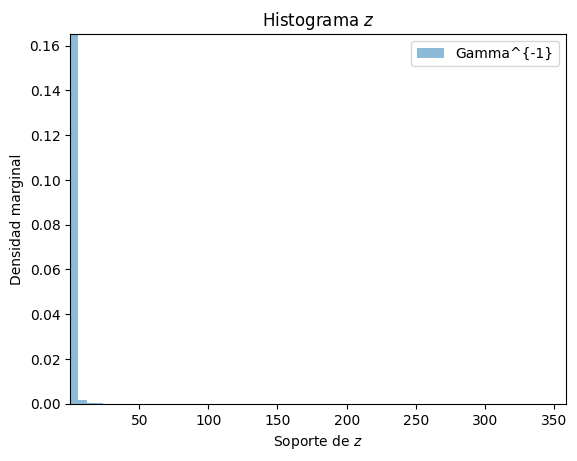

In [13]:
num_bins = 60
fig, (ax0) = plt.subplots(1,1)
ax0.hist(zs, num_bins, density=True, alpha=0.5, label='Gamma^{-1}')
ax0.set_xlabel('Soporte de $z$')
ax0.set_ylabel('Densidad marginal')
ax0.set_title(r'Histograma $z$')
ax0.legend()
ax0.autoscale(enable=True, axis='both', tight=True)

### Gibbs-sampling
Se requiere simular secuecnialmente $p(z|\mathbf{X})$ y $p(\mathbf{X}|z)$. En nuestro caso en particular $p(z|\mathbf{X})=p(z)$. Así que Gibbs-sampling se puede implementar de la siguiente manera:
1. Generamos los objetos para guardar los resultados

In [14]:
Xs_GS = mu.reshape((1,-1)) #*0+1000000
zs_GS = np.array([[Ez]])
nburn = 10**2

2. Implementando la recursión

In [15]:
for jj in range(1,nburn+nsample):
    z_jm1 = zs_GS[jj-1].item()  # Punto inicial para z (de recursión previa)
    X_jj  = np.random.multivariate_normal(mu, z_jm1*Omega, size=1)
    z_jj  = invgamma.rvs(a=alpha, scale=beta, size=1).reshape((1,-1))

    Xs_GS = np.r_[Xs_GS,X_jj]
    zs_GS = np.r_[zs_GS,z_jj]

Xs_GS=np.delete(Xs_GS, range(nburn), 0)
zs_GS=np.delete(zs_GS, range(nburn), 0)

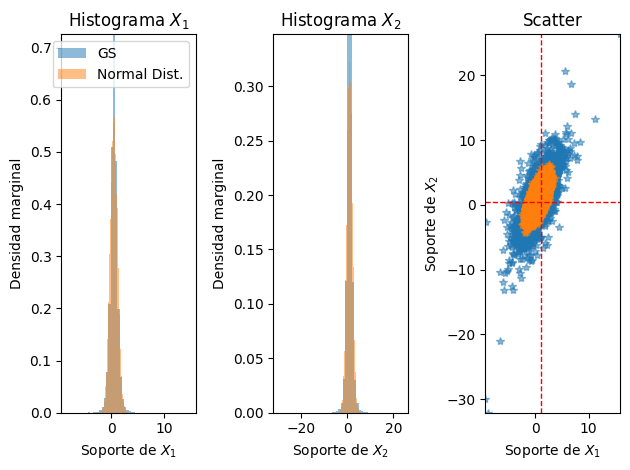

In [16]:
num_bins = 60
fig, (ax0, ax1, ax3) = plt.subplots(1,3)

ax0.hist(Xs_GS[:,0], num_bins, density=True, alpha=0.5, label='GS')
ax0.hist(Xs_normal[:, 0], num_bins, density=True, alpha=0.5, label='Normal Dist.')
ax0.set_xlabel('Soporte de $X_1$')
ax0.set_ylabel('Densidad marginal')
ax0.set_title(r'Histograma $X_1$')
ax0.legend()
ax0.autoscale(enable=True, axis='both', tight=True)

ax1.hist(Xs_GS[:,1], num_bins, density=True, alpha=0.5, label='GS')
ax1.hist(Xs_normal[:, 1], num_bins, density=True, alpha=0.5, label='Normal Dist.')
ax1.set_xlabel('Soporte de $X_2$')
ax1.set_ylabel('Densidad marginal')
ax1.set_title(r'Histograma $X_2$')
ax1.autoscale(enable=True, axis='both', tight=True)

ax3.plot(Xs_GS[:,0], Xs_GS[:,1], '*',alpha=0.5, label='GS')
ax3.plot(Xs_normal[:,0], Xs_normal[:,1], '*',alpha=0.5, label='Normal Dist.')
ax3.axhline(0.5, color='red', lw=1,ls='--')
ax3.axvline(1.0, color='red', lw=1,ls='--')
ax3.set_xlabel('Soporte de $X_1$')
ax3.set_ylabel('Soporte de $X_2$')
ax3.set_title(r'Scatter')
ax3.autoscale(enable=True, axis='both', tight=True)

plt.tight_layout()

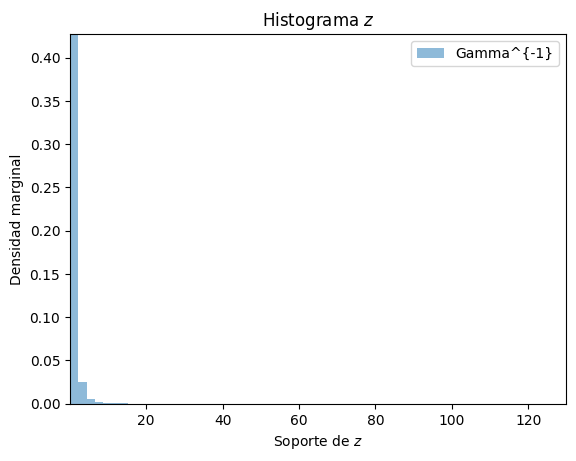

In [17]:
num_bins = 60
fig, (ax0) = plt.subplots(1,1)
ax0.hist(zs_GS, num_bins, density=True, alpha=0.5, label='Gamma^{-1}')
ax0.set_xlabel('Soporte de $z$')
ax0.set_ylabel('Densidad marginal')
ax0.set_title(r'Histograma $z$')
ax0.legend()
ax0.autoscale(enable=True, axis='both', tight=True)

### MH
1. Se necesita tener la capacidad de evaluar la densidad conjunta:
$$p(\mathbf{X},z)=p(\mathbf{X}|z)p(z)$$
$$p(\mathbf{X},z)=\frac{1}{(2\pi) |z\boldsymbol{\Omega}|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'(z\boldsymbol{\Omega})^{-1}(\mathbf{X} - \boldsymbol{\mu})\right)\frac{\beta^{\alpha}}{\Gamma(\alpha)}z^{-\alpha-1}\exp\left(-\frac{\beta}{z}\right)$$
$$p(\mathbf{X},z)=\frac{\beta^{\alpha}}{(2\pi) |\boldsymbol{\Omega}|^{1/2}\Gamma(\alpha)}\exp\left(-\frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'(z\boldsymbol{\Omega})^{-1}(\mathbf{X} - \boldsymbol{\mu})\right)z^{-\alpha-2}\exp\left(-\frac{\beta}{z}\right)$$
$$p(\mathbf{X},z)\propto\exp\left(-\frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'(z\boldsymbol{\Omega})^{-1}(\mathbf{X} - \boldsymbol{\mu})\right)z^{-\alpha-2}\exp\left(-\frac{\beta}{z}\right)$$
en logaritmos
$$\log p(\mathbf{X},z)\propto-(\alpha+2)\log z-\left[\beta+\frac{1}{2}(\mathbf{X} - \boldsymbol{\mu})'\boldsymbol{\Omega}^{-1}(\mathbf{X} - \boldsymbol{\mu})\right] z^{-1}$$

In [18]:
def logp_prop(w,mu,iOmega,alpha,beta):                                            # Define la función "logp_prop" con inputs w (punto evaluado para X,z) y mu, iOmega, alpha, beta (parámetros de las distribuciones, dados)
    X = w[:2].reshape(-1,1)                                                       # Compila los primeros dos elementos de w en un arreglo con una columna y dos filas
    z = w[2].item()                                                               # Asigna al objeto z el valor del segundo elemento de w
    if z<=0:
        return -10e100                                                            # Si z<=0, retorna un número negativo alto (-10*10**100)
    else:
        DX = X-mu.reshape(-1,1)                                                   # Notación. Define (X-mu)
        XX = np.dot(np.dot(DX.T,iOmega),DX)                                       # Notación. Define el producto matricial de interés
        return (-(alpha+2)*np.log(z)-(beta + 0.5*XX)/z ).item()                   # La función "logp_prop" retorna como outcome la función proporcional definida previamente.

2. Para definir un punto inicial (Del algoritmo de MH), calculamos la moda

In [19]:
# Punto inicial para busqueda de moda
iOmega = np.linalg.inv(Omega)                                                     # Invierte la matriz Omega, definida al inicio del ejercicio (simulación directa)
w0 = np.r_[mu.reshape((-1,1)),np.array([[Ez]])]                                   # Concatena los valores esperados de las variables aleatorias (X,z)

In [20]:
def get_mode(w): return -logp_prop(w,mu,iOmega,alpha,beta)                         # Define la función get_mode, con input w. Recordemos que alpha y beta son parámetros dados de la dist. Gamma. Puntos iniciales (iOmega, wo) definidos en la anterior linea.
res = minimize(get_mode, w0.reshape((-1,))*0+0.1, method='BFGS', options={'disp': True})    # Minimiza la función get_mode (función proporcional a distribución conjunta) respecto a w (variables aleatorias X,z). Les da valor inicial 0.1.

#'BFGS': algoritmo de optimización
# options={'disp': True}: Opcional. Muestra información sobre el progreso de la optimización.

Optimization terminated successfully.
         Current function value: -1.545177
         Iterations: 15
         Function evaluations: 80
         Gradient evaluations: 20


Recuperandola información de la moda

In [21]:
wmode = res.x                                                                       # Recuperamos los parámetros que minimizan la función proporcional (moda de la distribución conjunta)
varmode = res.hess_inv                                                              # Inversa de la Hessiana (segundas derivadas parciales), que es una aproximación de la matriz de covarianza de los parámetros
LTOmega = np.linalg.cholesky(varmode)                                               # Descomposición de Cholesky (producto de una matriz triangular inferior y su transpuesta) de la matriz varmode

3. Recursión de MH

Observe que a diferencia del algoritmo en las notas de clase, aquí se esta utilizando una versión en logaritmos

$$w^{*}=w^{(j-1)}+\varepsilon\text{ con }\varepsilon\sim\mathcal{N}(0,scale\times\Omega)$$

En las notas de clase, la probabilidad $\alpha$ es
$$\alpha=\min\left[\frac{f(w^{*})}{f(w^{(j-1)})},1\right]$$

En logaritmos se tiene:
$$\log\alpha=\min\left[\log f(w^{*}) - \log f(w^{(j-1)}),0\right]$$

De acuerdo con ello, la recursión principal es:

In [22]:
wsim = np.zeros(shape=(3,nburn+nsample))                                              # Crea arreglo de ceros con dos dimensiones (3 (variables aleatorias), nburn+nsample)
scale = 2.5 # 0.5 6                                                                   # Escala la varianza del término de perturbación. Ajustar para estabilizar ratio de aceptación (0.2-0.4)
for jj in range(nburn+nsample):
    if jj==0:
        wsim[:,jj] = np.ndarray.flatten(wmode)                                        # Definimos la moda calculada anteriormente como punto inicial de la recursión
        logp_old = logp_prop(wsim[:,jj],mu,iOmega,alpha,beta)                         # Generamos el primer draw de la función
        aceptance = 1
    else:                                                                             # Una vez iniciado el algoritmo...
        candidate = wsim[:,jj-1].reshape((-1,1))                                      # Toma el valor del último draw aceptado
        candidate = candidate + scale*np.dot(LTOmega,np.random.randn(3,1))            # Define el candidato de acuerdo a un Random Walk. El error se distribuye N(0,scale x Omega)
        eu = np.random.uniform(0,1)                                                   # Draw de una distribución U(0,1)
        if eu < 1e-20:
            u = -10**100                                                              # Si el draw es muy pequeño (10**-20), asigna un valor negativo alto
        else:
            u = np.log(eu).item()                                                     # De lo contrario, se obtiene el logaritmo natural del draw

        logp_new = logp_prop(candidate,mu,iOmega,alpha,beta)                          # Se calcula el valor de la densidad evaluada en el punto definido por el nuevo candidato
        logalpha = min( logp_new-logp_old,0 )                                         # Se define el valor de la función alpha (ver teoría)
        if u <= logalpha:                                                             # Si el logaritmo del draw de la uniforme es menor o igual al valor evaluado de alpha...
            wsim[:,jj] = np.ndarray.flatten(candidate)                                # Se acepta el candidato y lo compilamos en wsim
            logp_old = logp_new                                                       # Actualizamos el valor de la función proporcional con el candidato aceptado
            aceptance += 1
        else:
            wsim[:,jj] = wsim[:,jj-1]                                                 # De lo contrario, no se acepta el draw y se repite la iteración

wsim = np.delete(wsim, range(nburn), 1)                                               # Una vez terminada la iteraicón, se elimina el burning sample
aceptance = (aceptance/(nburn+nsample))*100                                           # Se calcula el ratio de aceptación (0.20 - 0.40)
aceptance

31.952047952047952

In [23]:
Xs_MH = wsim[:2,:].T                                                                  # Simulaciones de X
zs_MH = wsim[2,:].T                                                                   # Simulaciones de z

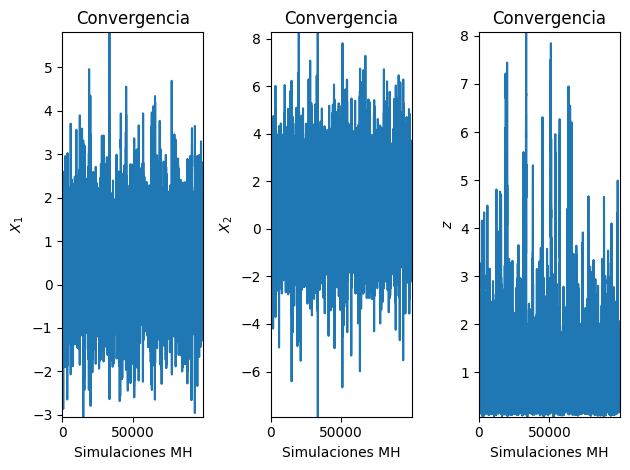

In [24]:
fig, axs = plt.subplots(1,3)                                                          # Gráfico de 3 subplots

line0, = axs[0].plot(Xs_MH[:,0])                                                      # Graficamos el valor de x1 de X=(x1,x2)' a lo largo de las simulaciones
axs[0].set_xlabel('Simulaciones MH')
axs[0].set_ylabel('$X_1$')
axs[0].set_title(r'Convergencia')
axs[0].autoscale(enable=True, axis='both', tight=True)

line1, = axs[1].plot(Xs_MH[:,1])                                                      # Graficamos x2 de X=(x1,x2)'
axs[1].set_xlabel('Simulaciones MH')
axs[1].set_ylabel('$X_2$')
axs[1].set_title(r'Convergencia')
axs[1].autoscale(enable=True, axis='both', tight=True)

line1, = axs[2].plot(zs_MH)                                                           # Graficamos z
axs[2].set_xlabel('Simulaciones MH')
axs[2].set_ylabel('$z$')
axs[2].set_title(r'Convergencia')
axs[2].autoscale(enable=True, axis='both', tight=True)


plt.tight_layout()

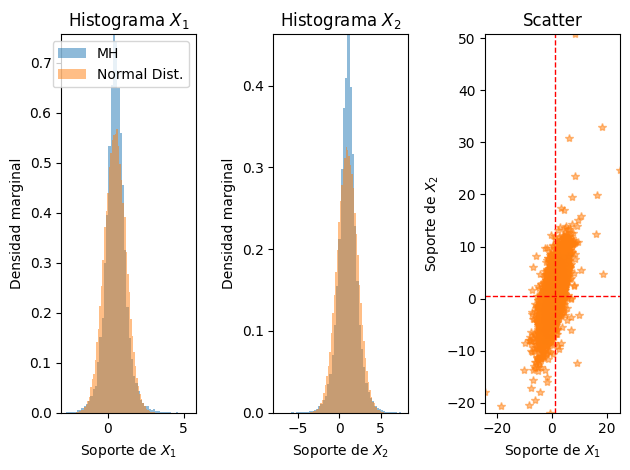

In [27]:
num_bins = 60
fig, (ax0, ax1, ax3) = plt.subplots(1,3)

ax0.hist(Xs_MH[:,0], num_bins, density=True, alpha=0.5, label='MH')
ax0.hist(Xs_normal[:, 0], num_bins, density=True, alpha=0.5, label='Normal Dist.')
ax0.set_xlabel('Soporte de $X_1$')
ax0.set_ylabel('Densidad marginal')
ax0.set_title(r'Histograma $X_1$')
ax0.legend()
ax0.autoscale(enable=True, axis='both', tight=True)

ax1.hist(Xs_MH[:,1], num_bins, density=True, alpha=0.5, label='MH')
ax1.hist(Xs_normal[:, 1], num_bins, density=True, alpha=0.5, label='Normal Dist.')
ax1.set_xlabel('Soporte de $X_2$')
ax1.set_ylabel('Densidad marginal')
ax1.set_title(r'Histograma $X_2$')
ax1.autoscale(enable=True, axis='both', tight=True)

ax3.plot(Xs_MH[:,0], Xs_MH[:,1], '*',alpha=0.5, label='MH')
ax3.plot(Xs[:,0], Xs[:,1], '*',alpha=0.5, label='Normal Dist.')
ax3.axhline(0.5, color='red', lw=1,ls='--')
ax3.axvline(1.0, color='red', lw=1,ls='--')
ax3.set_xlabel('Soporte de $X_1$')
ax3.set_ylabel('Soporte de $X_2$')
ax3.set_title(r'Scatter')
ax3.autoscale(enable=True, axis='both', tight=True)

plt.tight_layout()

In [ ]:
num_bins = 60
fig, (ax0, ax1, ax3) = plt.subplots(1,3)

ax0.hist(Xs_MH[:,0], num_bins, density=True, alpha=0.5, label='MH')
ax0.hist(Xs_normal[:, 0], num_bins, density=True, alpha=0.5, label='Normal Dist.')
ax0.set_xlabel('Soporte de $X_1$')
ax0.set_ylabel('Densidad marginal')
ax0.set_title(r'Histograma $X_1$')
ax0.legend()
ax0.autoscale(enable=True, axis='both', tight=True)

ax1.hist(Xs_MH[:,1], num_bins, density=True, alpha=0.5, label='MH')
ax1.hist(Xs_normal[:, 1], num_bins, density=True, alpha=0.5, label='Normal Dist.')
ax1.set_xlabel('Soporte de $X_2$')
ax1.set_ylabel('Densidad marginal')
ax1.set_title(r'Histograma $X_2$')
ax1.autoscale(enable=True, axis='both', tight=True)

ax3.plot(Xs_MH[:,0], Xs_MH[:,1], '*',alpha=0.5, label='MH')
ax3.plot(Xs_normal[:,0], Xs_normal[:,1], '*',alpha=0.5, label='Normal Dist.')
ax3.axhline(0.5, color='red', lw=1,ls='--')
ax3.axvline(1.0, color='red', lw=1,ls='--')
ax3.set_xlabel('Soporte de $X_1$')
ax3.set_ylabel('Soporte de $X_2$')
ax3.set_title(r'Scatter')
ax3.autoscale(enable=True, axis='both', tight=True)

plt.tight_layout()

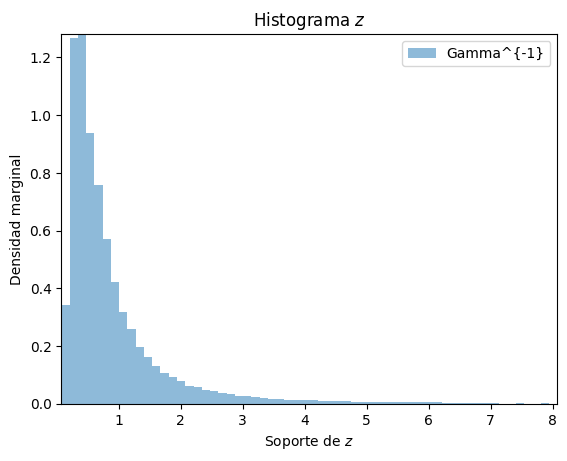

In [26]:
num_bins = 60
fig, (ax0) = plt.subplots(1,1)
ax0.hist(zs_MH, num_bins, density=True, alpha=0.5, label='Gamma^{-1}')
ax0.set_xlabel('Soporte de $z$')
ax0.set_ylabel('Densidad marginal')
ax0.set_title(r'Histograma $z$')
ax0.legend()
ax0.autoscale(enable=True, axis='both', tight=True)